# Load Libraries

In [1]:
!pip install kaggle

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from google.colab import files

from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import tensorflow as tf
import ydf
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder

from sklearn.metrics import mean_squared_error,r2_score

from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + ydf.__version__)

TensorFlow v2.19.0
TensorFlow Decision Forests v0.13.0


# Load Dataset

In [13]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srilutfiyadwiyeni","key":"03d457b338392a43b5e6ba5541e10a4f"}'}

In [14]:
!ls

kaggle.json  sample_data  train.csv


In [15]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [16]:
!ls /root/.kaggle

kaggle.json


In [17]:
!kaggle competitions list

ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3    2026-04-15 23:59:00  Featured         2,207,152 Usd       1374           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection         2026-02-13 23:59:00  Research           200,000 Usd        637           False  
https://www.kaggle.com/competitions/med-gemma-impact-challenge                   2026-02-24 23:59:00  Featured           100,000 Usd         22           False  
https://www.kaggle.com/competitions/csiro-biomass                                2026-01-28 23:59:00  Research            75,000 Usd       3482           False  
https://www.kaggle.com/compe

In [18]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 509MB/s]


In [19]:
!unzip house-prices-advanced-regression-techniques.zip -d house_prices_data

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: house_prices_data/data_description.txt  
  inflating: house_prices_data/sample_submission.csv  
  inflating: house_prices_data/test.csv  
  inflating: house_prices_data/train.csv  


In [20]:
!ls house_prices_data

data_description.txt  sample_submission.csv  test.csv  train.csv


In [78]:
train_file_path = "/content/house_prices_data/train.csv"
test_file_path = "/content/house_prices_data/test.csv"
df_test = pd.read_csv(test_file_path)
df = pd.read_csv(train_file_path)

In [79]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [81]:
print("train_shape: ", df.shape)
print("test_shape: ", df_test.shape)

train_shape:  (1460, 81)
test_shape:  (1459, 80)


# Data Preprocessing

## Missing Value Handling

In [91]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [92]:
mv=df.isnull().sum()
mv=mv[mv>0].sort_values(ascending=False)
mv.head(25)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81


In [99]:
df_clean = df.copy()

none_cols = [
    'PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
    'GarageType','GarageFinish','GarageQual','GarageCond',
    'BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual','BsmtCond',
    'MasVnrType'
]

df_clean[none_cols] = df_clean[none_cols].fillna('No')

df_clean['MasVnrArea'] = df_clean['MasVnrArea'].fillna(0)
df_clean['GarageYrBlt'] = df_clean['GarageYrBlt'].fillna(0)

df_clean['LotFrontage'] = df_clean.groupby('Neighborhood')['LotFrontage'] \
                                  .transform(lambda x: x.fillna(x.median()))

df_clean['Electrical'] = df_clean['Electrical'].fillna(df_clean['Electrical'].mode()[0])

In [100]:
df_clean.isnull().sum().sort_values(ascending=False).head(10)

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0
Street,0
Alley,0
LotShape,0
LandContour,0
Utilities,0


In [101]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [103]:
df_clean.to_csv('/content/drive/MyDrive/house_prices_train_clean.csv', index=False)

train_df = pd.read_csv('/content/drive/MyDrive/house_prices_train_clean.csv')

train_df.isnull().sum().sort_values(ascending=False).head(10)

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0
Street,0
Alley,0
LotShape,0
LandContour,0
Utilities,0


## Duplicate Data

In [60]:
df_clean.duplicated().sum()

np.int64(0)

## Outlier Checking

In [61]:
df_clean.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.199658,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.431902,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [62]:
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
print(f"Total numeric columns: {len(num_cols)}")
print(num_cols)

Total numeric columns: 38
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [63]:
def detect_outliers_iqr(df, columns):
    outlier_summary = {}

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        outlier_summary[col] = len(outliers)

    return pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['outlier_count']).sort_values(by='outlier_count', ascending=False)


iqr_outliers = detect_outliers_iqr(df_clean, num_cols)
iqr_outliers.head(10)

,outlier_count
EnclosedPorch,208
BsmtFinSF2,167
OverallCond,125
ScreenPorch,116
MSSubClass,103
MasVnrArea,98
LotFrontage,93
BsmtHalfBath,82
GarageYrBlt,81
OpenPorchSF,77


In [64]:
Q1 = df_clean['SalePrice'].quantile(0.25)
Q3 = df_clean['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

saleprice_outliers = df_clean[(df_clean['SalePrice'] < lower) | (df_clean['SalePrice'] > upper)]

print(f"Total SalePrice outliers: {saleprice_outliers.shape[0]}")
saleprice_outliers[['Id', 'SalePrice']].sort_values(by='SalePrice', ascending=False).head()

Total SalePrice outliers: 61


,Id,SalePrice
691,692,755000
1182,1183,745000
1169,1170,625000
898,899,611657
803,804,582933


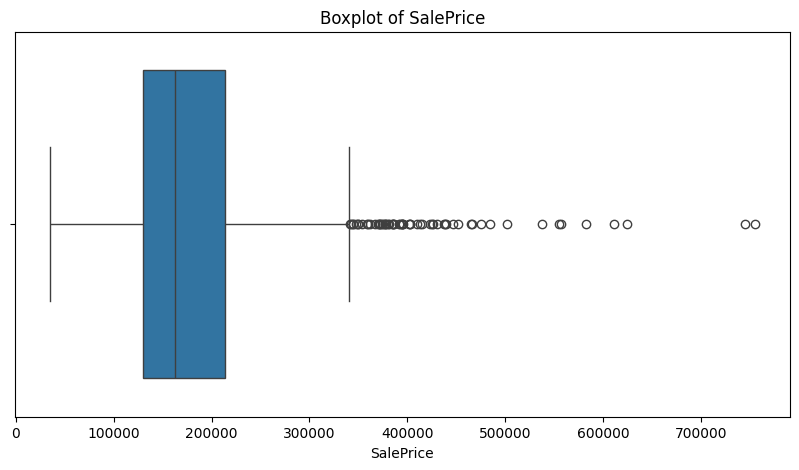

In [65]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_clean['SalePrice'])
plt.title("Boxplot of SalePrice")
plt.show()

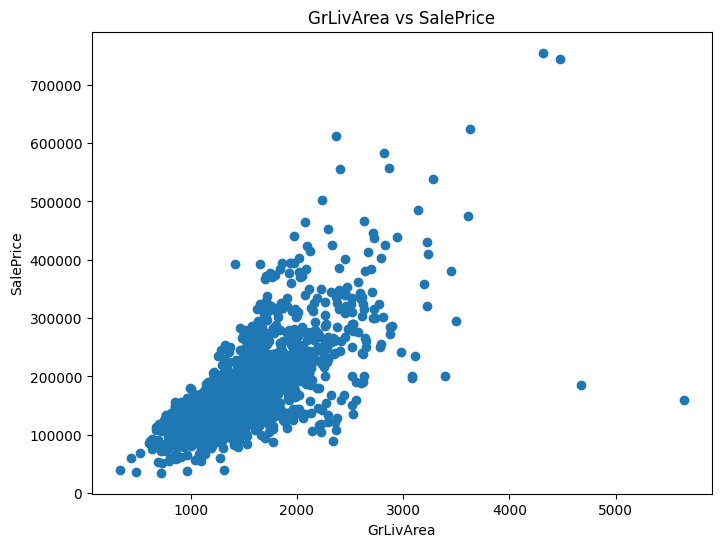

In [66]:
plt.figure(figsize=(8,6))
plt.scatter(df_clean['GrLivArea'], df_clean['SalePrice'])
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("GrLivArea vs SalePrice")
plt.show()

In [67]:
z_scores = np.abs(stats.zscore(df_clean[num_cols]))
outliers_z = (z_scores > 3).any(axis=1)

df_z_outliers = df_clean[outliers_z]
print(f"Total outliers (Z-score): {df_z_outliers.shape[0]}")

Total outliers (Z-score): 491


In [68]:
# Membersihkan outliers yang ekstrim pada fitur GrLivArea
df_clean = df_clean.drop(df_clean[(df_clean['GrLivArea'] > 4000) & (df_clean['SalePrice'] < 300000)].index)

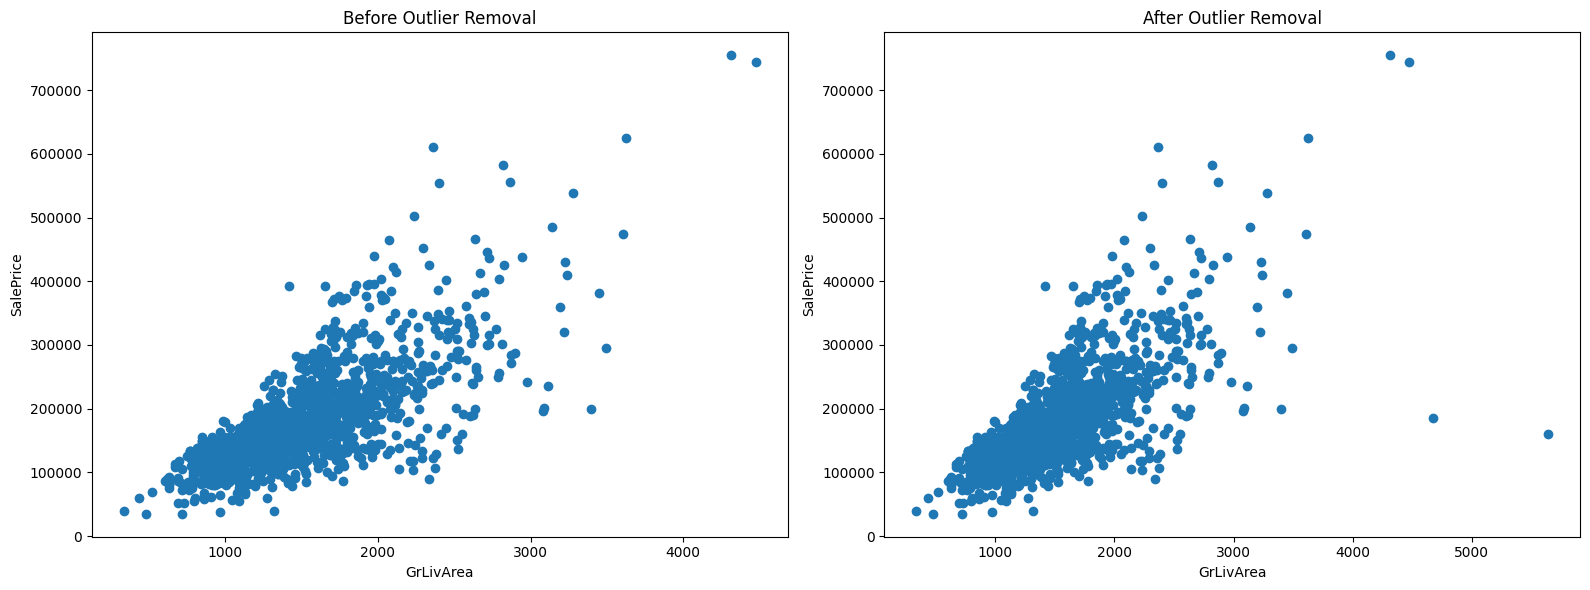

In [69]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(df_clean['GrLivArea'], df_clean['SalePrice'])
axes[0].set_title("Before Outlier Removal")
axes[0].set_xlabel("GrLivArea")
axes[0].set_ylabel("SalePrice")

axes[1].scatter(df['GrLivArea'], df['SalePrice'])
axes[1].set_title("After Outlier Removal")
axes[1].set_xlabel("GrLivArea")
axes[1].set_ylabel("SalePrice")

plt.tight_layout()
plt.show()

# Exploratory Data Analysis (EDA)

## SalePrice Distribution

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


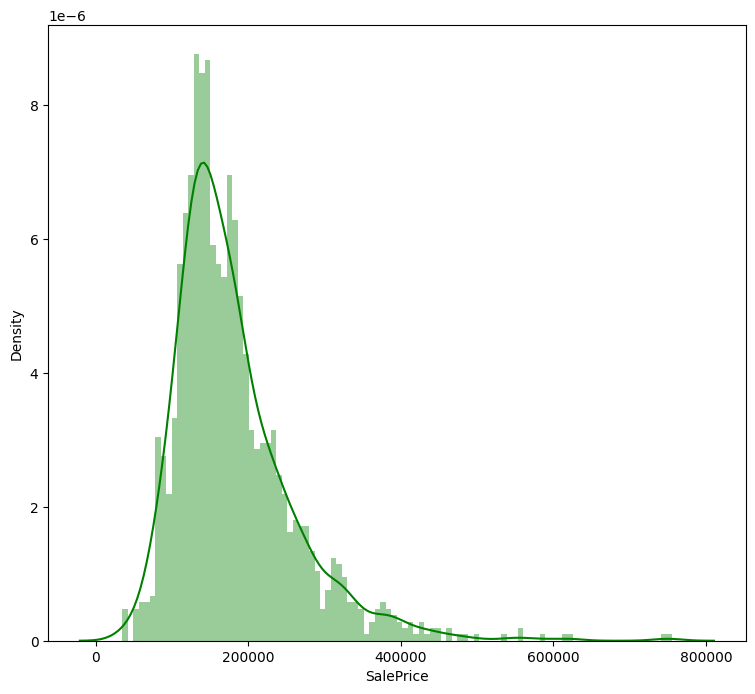

In [ ]:
print(df_clean['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df_clean['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

## LotShape Distribution

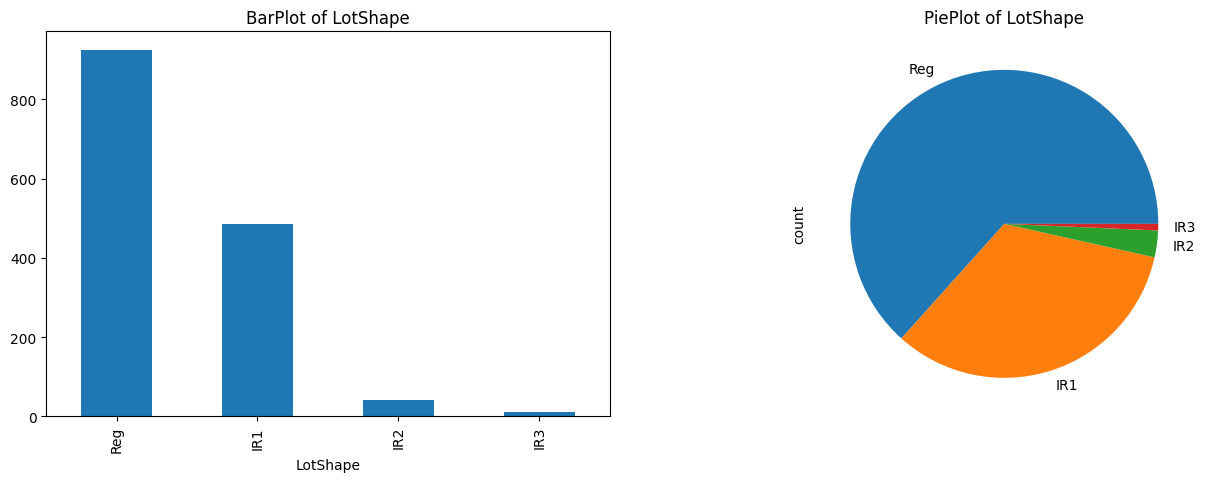

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
df_clean["LotShape"].value_counts().plot(kind='bar')
plt.title("BarPlot of LotShape")

plt.subplot(1,2,2)
df_clean["LotShape"].value_counts().plot(kind='pie')
plt.title("PiePlot of LotShape")
plt.show()

## Street Distribution

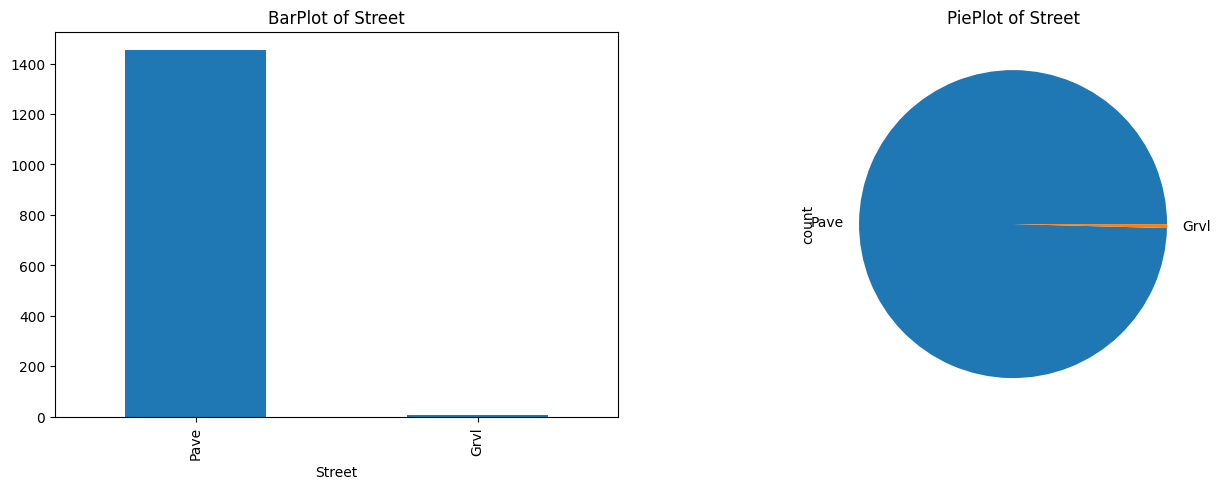

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
df["Street"].value_counts().plot(kind='bar')
plt.title("BarPlot of Street")

plt.subplot(1,2,2)
df["Street"].value_counts().plot(kind='pie')
plt.title("PiePlot of Street")
plt.show()

## Alley Distribution

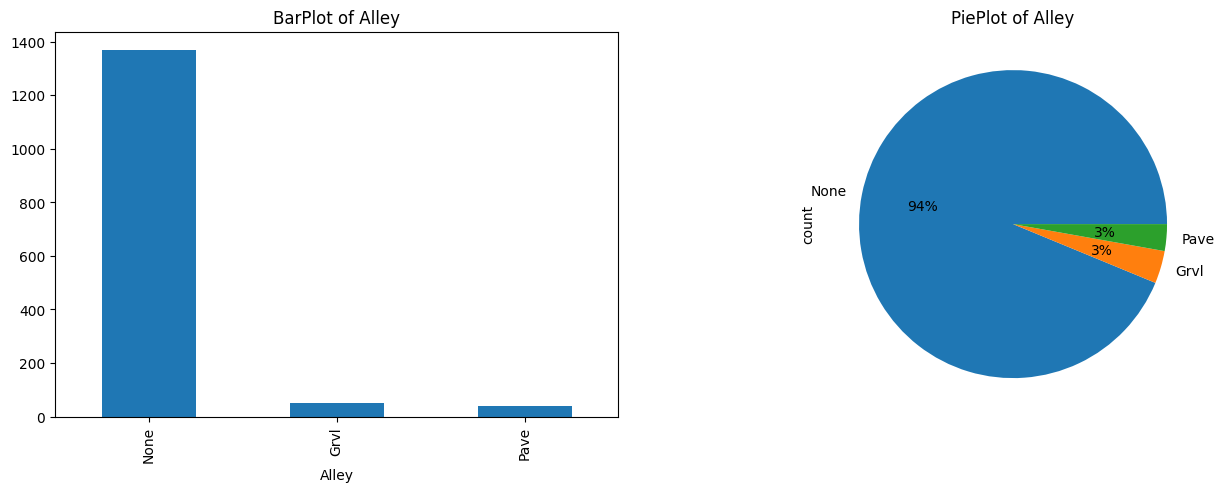

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
df["Alley"].value_counts().plot(kind='bar')
plt.title("BarPlot of Alley")

plt.subplot(1,2,2)
df["Alley"].value_counts().plot(kind='pie',autopct='%1.f%%')
plt.title("PiePlot of Alley")
plt.show()

## MSZoning Distribution

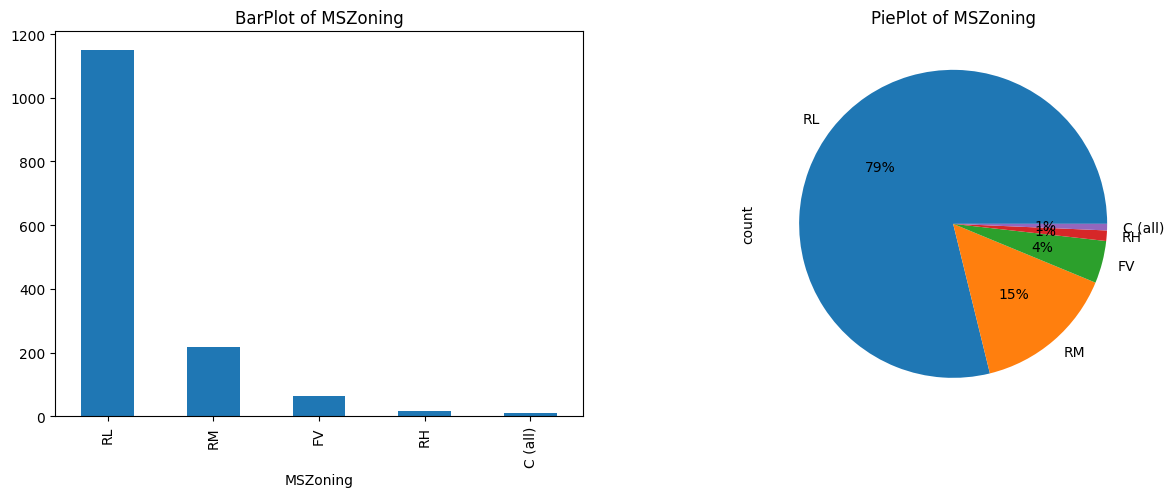

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df_clean["MSZoning"].value_counts().plot(kind='bar')
plt.title("BarPlot of MSZoning")

plt.subplot(1,2,2)
df_clean["MSZoning"].value_counts().plot(kind='pie',autopct='%1.f%%')
plt.title("PiePlot of MSZoning")
plt.show()

## Numerical Data Distribution

In [ ]:
df_clean_num = df_clean.select_dtypes(include=['float64', 'int64']).drop(columns=['Id'])
df_clean_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


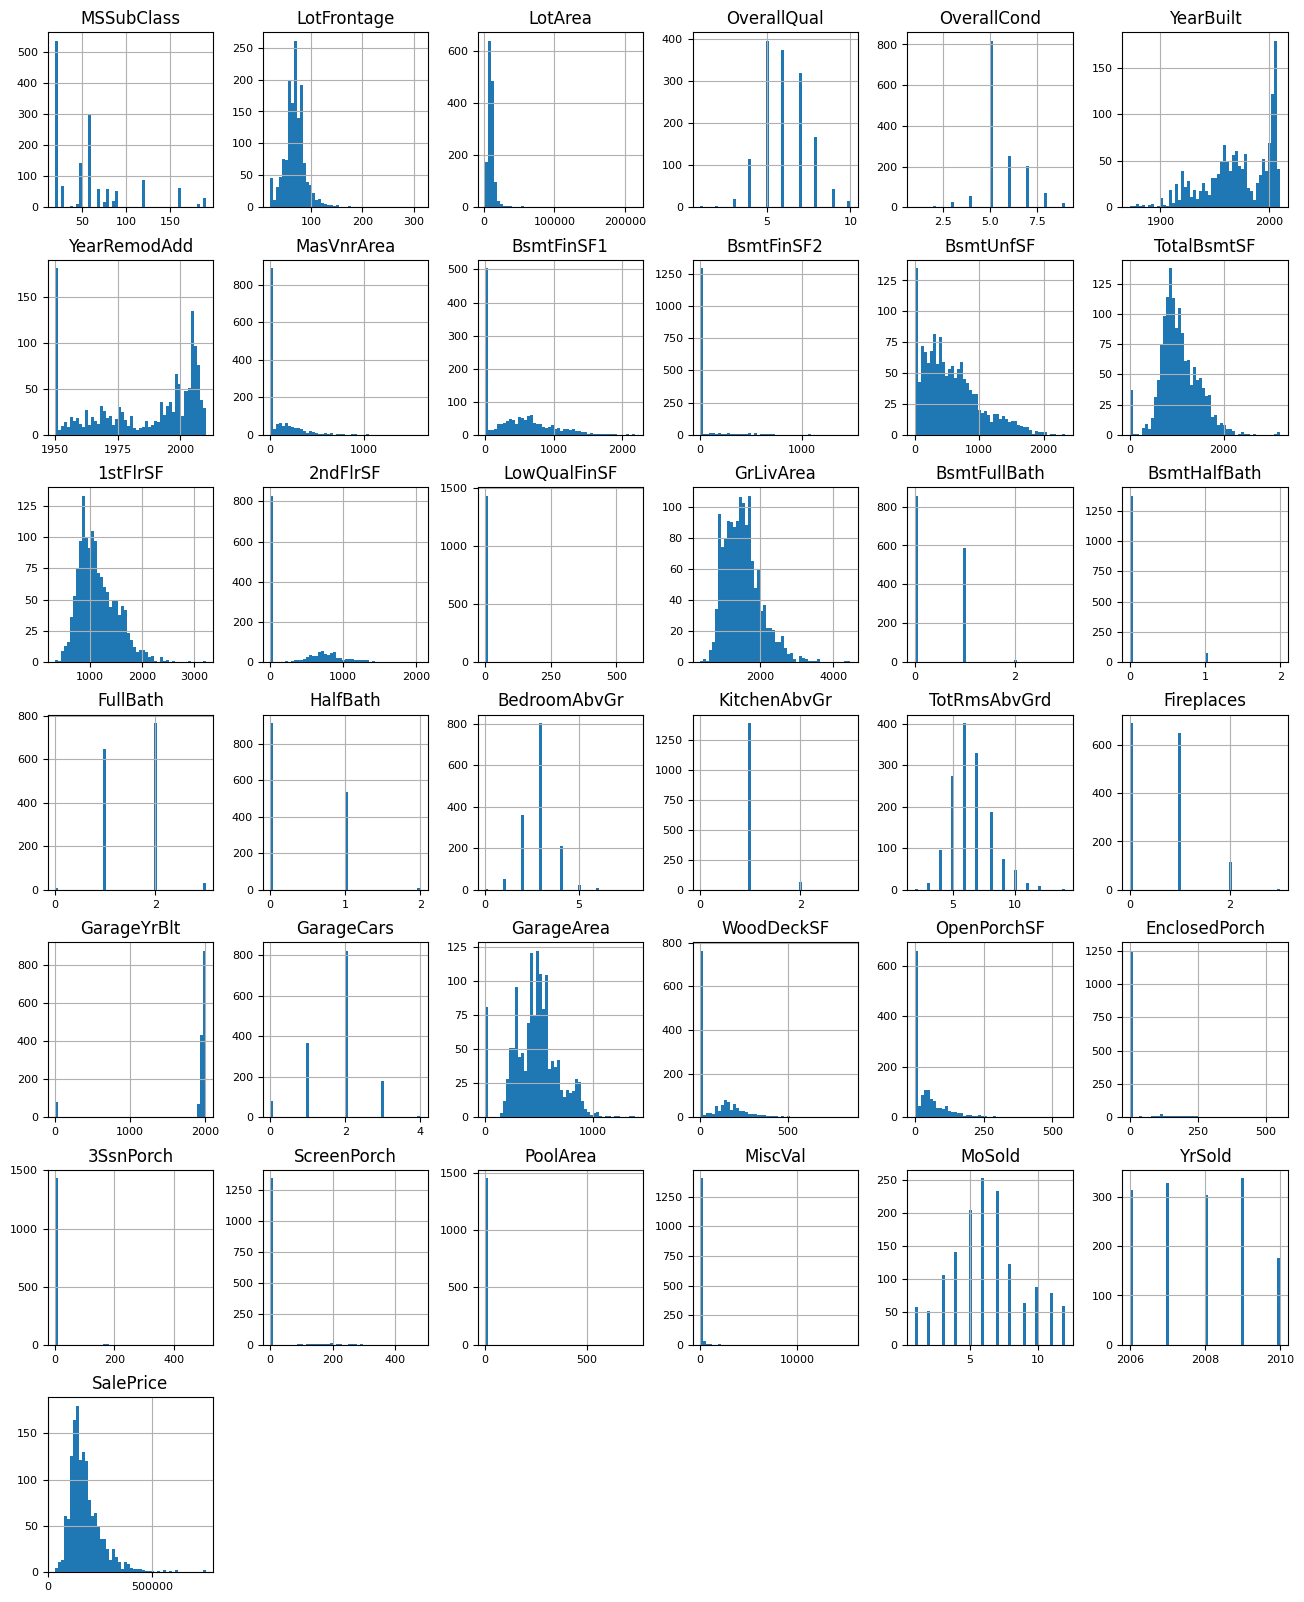

In [ ]:
df_clean_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

# Feature Engineering

In [ ]:
# Total square feet
df_clean["TotalSF"] = df_clean["TotalBsmtSF"] + df_clean["1stFlrSF"] + df_clean["2ndf_cleanlrSF"]

# House age
df_clean["HouseAge"] = df_clean["YrSold"] - df_clean["YearBuilt"]

# Remodel age
df_clean["RemodAge"] = df_clean["YrSold"] - df_clean["YearRemodAdd"]

df_clean[["TotalSF", "HouseAge", "RemodAge"]].head()

,TotalSF,HouseAge,RemodAge
0,2566,5,5
1,2524,31,31
2,2706,7,6
3,2473,91,36
4,3343,8,8


## Splitting Features and Target

In [ ]:
X = df_clean.drop(columns=["SalePrice", "Id"])
y = df_clean["SalePrice"]
y_log = np.log1p(y)

print("X shape:", X.shape)
print("y_log shape:", y_log.shape)

X shape: (1458, 82)
y_log shape: (1458,)


In [ ]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

print("Numeric features:", len(num_features))
print("Categorical features:", len(cat_features))

Numeric features: 39
Categorical features: 43


# Modeling

## Pipeline Preprocessing

In [ ]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])

## GWO Class

In [ ]:
class GreyWolfOptimizer:
    def __init__(self, model_class, param_bounds, preprocessor, X, y, cv=3, n_wolves=5, n_iter=10, random_state=42):
        self.model_class = model_class
        self.param_bounds = param_bounds
        self.preprocessor = preprocessor
        self.X = X
        self.y = y
        self.cv = cv
        self.n_wolves = n_wolves
        self.n_iter = n_iter
        self.random_state = random_state
        np.random.seed(self.random_state)

    def _init_wolves(self):
        wolves = []
        for _ in range(self.n_wolves):
            wolf = {}
            for param, bounds in self.param_bounds.items():
                wolf[param] = np.random.uniform(bounds[0], bounds[1])
            wolves.append(wolf)
        return wolves

    def _fitness(self, wolf):
        params = {k: int(v) for k, v in wolf.items()}

        model = self.model_class(**params, random_state=self.random_state)

        pipeline = Pipeline(steps=[
            ("preprocessor", self.preprocessor),
            ("model", model)
        ])

        scores = cross_val_score(
            pipeline,
            self.X,
            self.y,
            cv=self.cv,
            scoring="neg_root_mean_squared_error"
        )

        return np.mean(scores)

    def optimize(self):
        wolves = self._init_wolves()

        for iteration in range(self.n_iter):
            fitness_scores = [self._fitness(wolf) for wolf in wolves]
            sorted_idx = np.argsort(fitness_scores)[::-1]

            alpha = wolves[sorted_idx[0]]
            beta = wolves[sorted_idx[1]]
            delta = wolves[sorted_idx[2]]

            a = 2 - iteration * (2 / self.n_iter)

            for i in range(self.n_wolves):
                for param in self.param_bounds:
                    r1, r2 = np.random.rand(), np.random.rand()
                    A1 = 2 * a * r1 - a
                    C1 = 2 * r2
                    D_alpha = abs(C1 * alpha[param] - wolves[i][param])
                    X1 = alpha[param] - A1 * D_alpha

                    r1, r2 = np.random.rand(), np.random.rand()
                    A2 = 2 * a * r1 - a
                    C2 = 2 * r2
                    D_beta = abs(C2 * beta[param] - wolves[i][param])
                    X2 = beta[param] - A2 * D_beta

                    r1, r2 = np.random.rand(), np.random.rand()
                    A3 = 2 * a * r1 - a
                    C3 = 2 * r2
                    D_delta = abs(C3 * delta[param] - wolves[i][param])
                    X3 = delta[param] - A3 * D_delta

                    wolves[i][param] = (X1 + X2 + X3) / 3
                    low, high = self.param_bounds[param]
                    wolves[i][param] = np.clip(wolves[i][param], low, high)

            print(f"Iteration {iteration+1}/{self.n_iter} | Best RMSE: {-fitness_scores[sorted_idx[0]]:.4f}")

        best_params = {k: int(v) for k, v in alpha.items()}
        return best_params

In [ ]:
param_bounds = {
    "n_estimators": (150, 400),
    "max_depth": (5, 30),
    "min_samples_split": (2, 10)
}

In [ ]:
gwo = GreyWolfOptimizer(
    model_class=RandomForestRegressor,
    param_bounds=param_bounds,
    preprocessor=preprocessor,
    X=X,
    y=y_log,
    n_wolves=5,
    n_iter=10
)

best_params = gwo.optimize()
print("Best Parameters from GWO:", best_params)

Iteration 1/10 | Best RMSE: 0.1404
Iteration 2/10 | Best RMSE: 0.1400
Iteration 3/10 | Best RMSE: 0.1396
Iteration 4/10 | Best RMSE: 0.1396
Iteration 5/10 | Best RMSE: 0.1394
Iteration 6/10 | Best RMSE: 0.1396
Iteration 7/10 | Best RMSE: 0.1400
Iteration 8/10 | Best RMSE: 0.1398
Iteration 9/10 | Best RMSE: 0.1400
Iteration 10/10 | Best RMSE: 0.1403
Best Parameters from GWO: {'n_estimators': 228, 'max_depth': 11, 'min_samples_split': 2}


In [ ]:
best_model = RandomForestRegressor(**best_params, random_state=42)

final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_model)
])

final_pipeline.fit(X, y_log)

print("Final model trained.")

Final model trained.


# Save Model

In [ ]:
joblib.dump(final_pipeline, "house_price_gwo_log_fe_model.pkl")
print("Model saved as house_price_gwo_log_fe_model.pkl")

Model saved as house_price_gwo_log_fe_model.pkl


# Prediction Test

In [ ]:
sample = X.sample(5, random_state=42)
log_preds = final_pipeline.predict(sample)
preds = np.expm1(log_preds)

result = sample.copy()
result["PredictedSalePrice"] = preds
result

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,HouseAge,RemodAge,PredictedSalePrice
1322,60,RL,107.0,10186,Pave,None,IR1,Lvl,AllPub,Inside,...,None,0,6,2010,WD,Normal,2673,18,18,200423.986067
837,160,RM,21.0,1680,Pave,None,Reg,Lvl,AllPub,Inside,...,None,0,11,2008,WD,Normal,1470,35,35,96041.184808
413,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,None,0,3,2010,WD,Normal,2036,83,60,112743.971519
522,50,RM,50.0,5000,Pave,None,Reg,Lvl,AllPub,Corner,...,None,0,10,2006,WD,Normal,2668,59,56,155660.623063
1036,20,RL,89.0,12898,Pave,None,IR1,HLS,AllPub,Inside,...,None,0,9,2009,WD,Normal,3240,2,1,310908.858901


# Model Evaluasi RMSE

In [ ]:
from sklearn.metrics import mean_squared_error

log_preds_full = final_pipeline.predict(X)
preds_full = np.expm1(log_preds_full)

rmse = np.sqrt(mean_squared_error(y, preds_full))
print(f"Final RMSE (real scale): {rmse:.2f}")

Final RMSE (real scale): 10601.39
